In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(figsize = [10,8],dpi =100, facecolor='white')

import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy

vir = copy(mpl.cm.viridis)
vir.set_under("lightgray")

In [ ]:
adata_ko = sc.read_h5ad('AP_KO_BRN12.h5ad')
adata_ko = adata_ko[adata_ko.obs['Batch']!=1,:]

In [ ]:
adata_ko.obs['Batch'] = adata_ko.obs['Batch'].astype('category')
adata_ko.obs['age.x'] = adata_ko.obs['age.x'].astype('category')
adata_ko.obs['Batch.x'] = adata_ko.obs['Batch.x'].astype('category')

In [ ]:
adata_ct = sc.read_h5ad('AP_CONTROL_BRN12.h5ad')
adata_ct = adata_ct[adata_ct.obs['Batch']!=1,:]

In [ ]:
adata_ct = adata_ct[adata_ct.obs['Batch']!=1,:]
adata_ct.var_names_make_unique()

adata_ct.layers['plot'] = np.log1p(adata_ct.X)
adata_ct.layers['count'] = adata_ct.X.copy()

adata_ct.obs['Batch'] = adata_ct.obs['Batch'].astype('category')
adata_ct.obs['age.x'] = adata_ct.obs['age.x'].astype('category')

adata_ct.obs['pseudotime'] = pd.read_csv('ct_pseudotime.csv')['pseudotime'].values

In [7]:
adata_ct.var_names_make_unique()
adata_ko.var_names_make_unique()

In [ ]:
adata = adata_ct.concatenate(adata_ko)

In [9]:
del adata_ct, adata_ko

In [10]:
adata.layers['plot'] = np.log1p(adata.X)
adata.layers['count'] = adata.X.copy()

adata.obs['Batch'] = adata.obs['Batch'].astype('category')
adata.obs['age.x'] = adata.obs['age.x'].astype('category')
adata.obs['Batch.x'] = adata.obs['Batch.x'].astype('category')

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [11]:
sc.pp.highly_variable_genes(adata,max_mean = 10,batch_key = 'sex.x')

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
adata.var.highly_variable.value_counts()

highly_variable
False    25794
True      1846
Name: count, dtype: int64

In [13]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


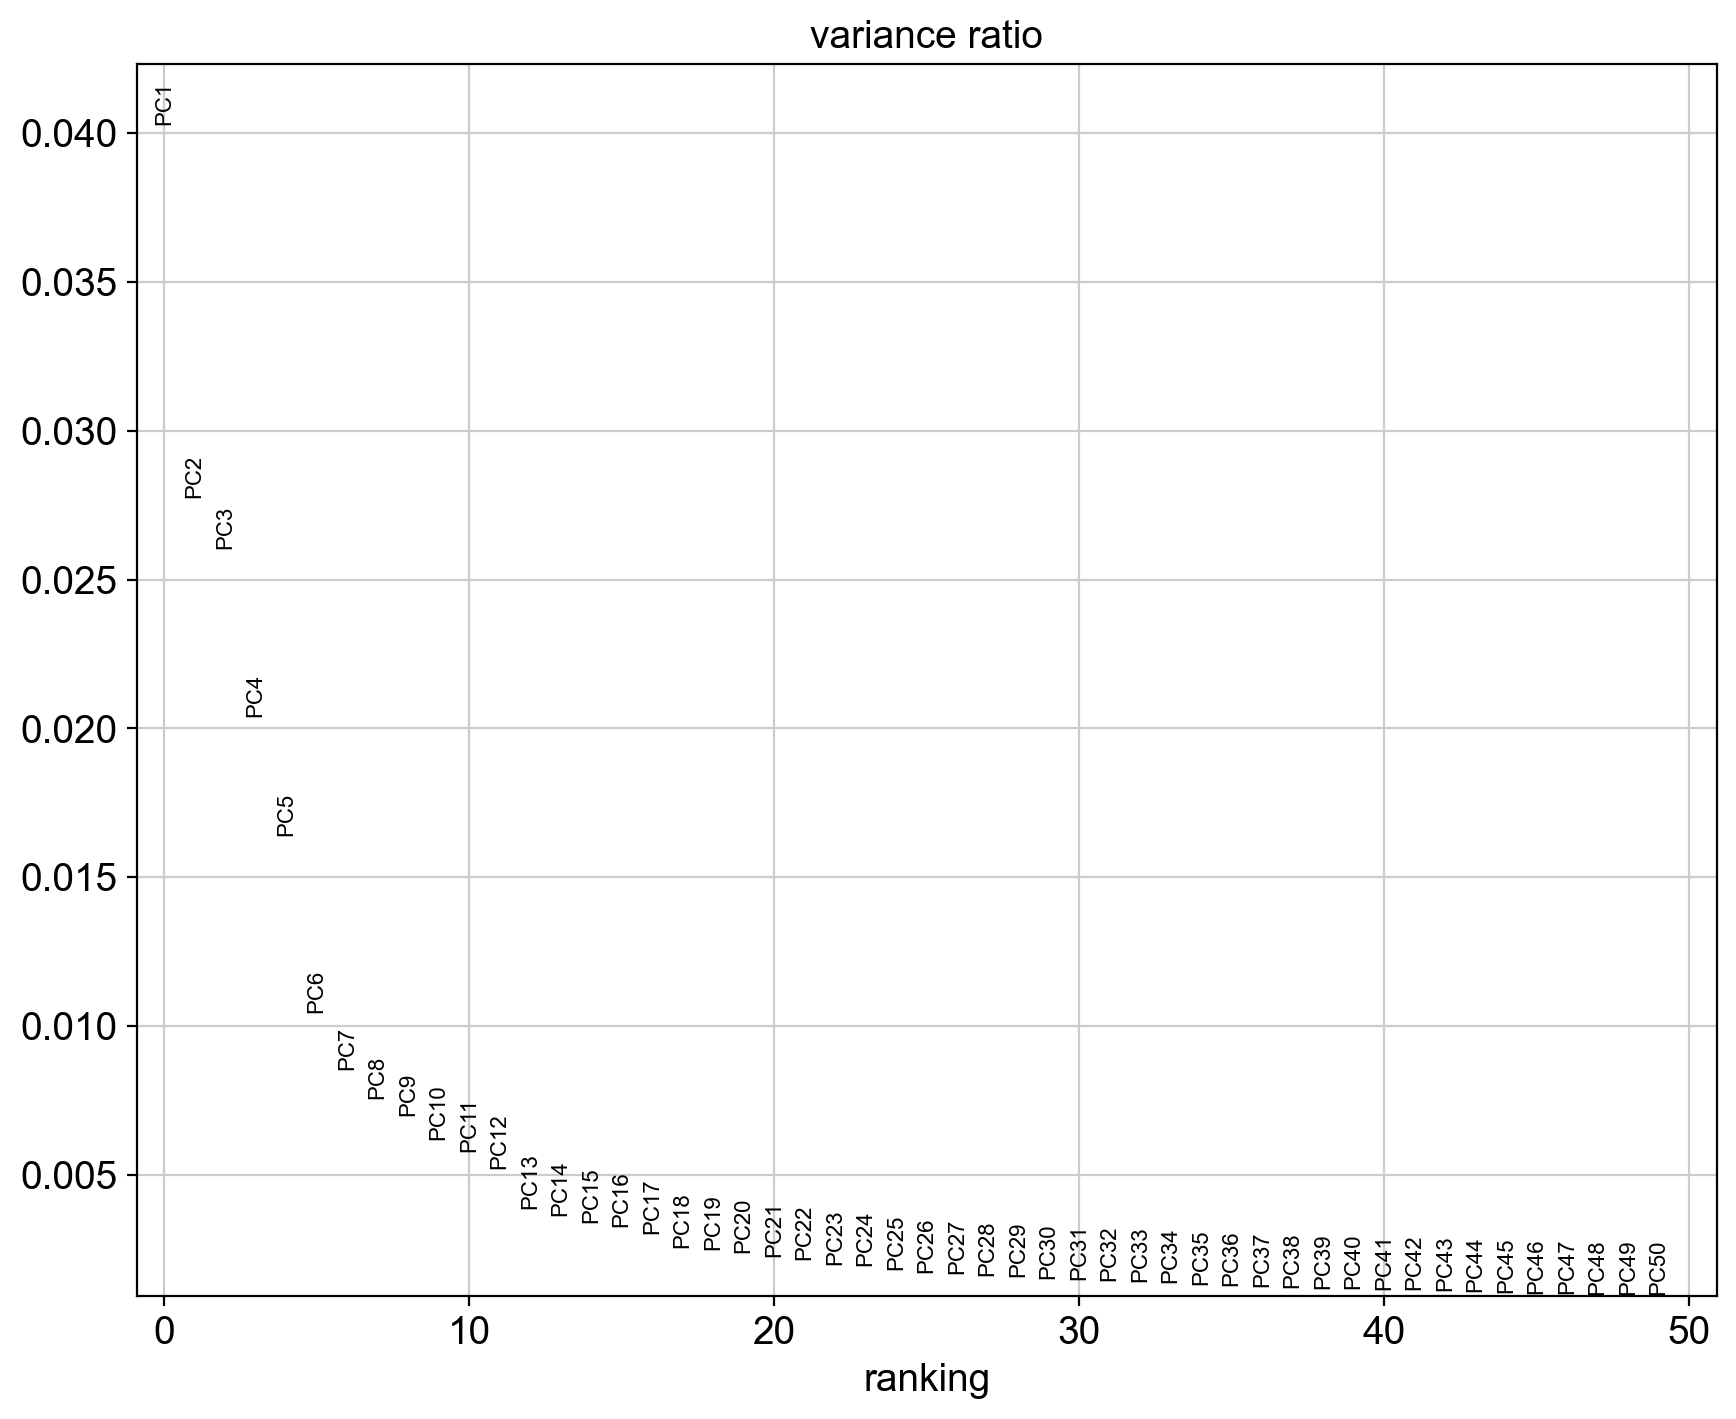

In [14]:
sc.tl.pca(adata,svd_solver = 'auto',use_highly_variable = True)
sc.pl.pca_variance_ratio(adata,n_pcs=50)

In [15]:
from scipy.spatial import cKDTree

In [16]:
tree = cKDTree(adata[adata.obs['condition'] == 'control',].obsm['X_pca'])

In [17]:
d,i = tree.query(adata[adata.obs['condition'] == 'ko',].obsm['X_pca'], k = 1, workers = -1)

In [18]:
pseudotime = pd.read_csv('ct_pseudotime.csv')

In [19]:
pseudotime['pseudotime'].values[i]

array([0.5642101 , 0.35005862, 0.71406597, ..., 0.17841919, 0.5866242 ,
       0.32597858])

In [22]:
pd.DataFrame(pseudotime['pseudotime'].values[i]).to_csv('KO_pseudotime_similarity.csv')